# Predicting catalog demands and profits

### The Business Problem
You recently started working for a company that manufactures and sells high-end home goods. Last year the company sent out its first print catalog, and is preparing to send out this year's catalog in the coming months. The company has 250 new customers from their mailing list that they want to send the catalog to.

Your manager has been asked to determine how much profit the company can expect from sending a catalog to these customers. You, the business analyst, are assigned to help your manager run the numbers. While fairly knowledgeable about data analysis, your manager is not very familiar with predictive models.

You’ve been asked to predict the expected profit from these 250 new customers. Management does not want to send the catalog out to these new customers unless the expected profit contribution exceeds $10,000.

#### Details
- The costs of printing and distributing is \$6.50 per catalog.
- The average gross margin (price - cost) on all products sold through the catalog is 50%.
- Make sure to multiply your revenue by the gross margin first before you subtract out the \$6.50 cost when calculating your profit.


In [78]:
import sys
# !{sys.executable} -m pip install plotly

In [79]:
# Auto reload all .py file
%load_ext autoreload
%autoreload

from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.express as px
import seaborn as sb
import torch
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
                            GradientBoostingClassifier, GradientBoostingRegressor, \
                            AdaBoostRegressor, RandomForestRegressor
from sklearn import svm
from lightgbm import LGBMClassifier, LGBMRegressor
import xgboost
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tqdm import tqdm


# import setting as setting
# import helper as helper

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline

# check if CUDA is available
use_cuda = torch.cuda.is_available()
print(use_cuda)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False


In [80]:
# Reading the data
df_p1_customers = pd.read_excel('All_P1_Files/p1-customers.xlsx', sheet_name='p1-customers')
df_p1_mailinglist = pd.read_excel('All_P1_Files/p1-mailinglist.xlsx', sheet_name='p1-mailinglist')


# Exploratory Data Analysis

In [4]:
# checking datatype for the df_p1_customers
df_p1_customers.dtypes

Name                           object
Customer_Segment               object
Customer_ID                     int64
Address                        object
City                           object
State                          object
ZIP                             int64
Avg_Sale_Amount               float64
Store_Number                    int64
Responded_to_Last_Catalog      object
Avg_Num_Products_Purchased      int64
#_Years_as_Customer             int64
dtype: object

In [5]:
# checking datatype for the df_p1_mailinglist
df_p1_mailinglist.dtypes

Name                           object
Customer_Segment               object
Customer_ID                     int64
Address                        object
City                           object
State                          object
ZIP                             int64
Store_Number                    int64
Avg_Num_Products_Purchased      int64
#_Years_as_Customer           float64
Score_No                      float64
Score_Yes                     float64
dtype: object

In [6]:
df_p1_customers['ZIP'] = df_p1_customers['ZIP'].astype('str')
df_p1_mailinglist['ZIP'] = df_p1_mailinglist['ZIP'].astype('str')

df_p1_customers['Store_Number'] = df_p1_customers['Store_Number'].astype('str')
df_p1_mailinglist['Store_Number'] = df_p1_mailinglist['Store_Number'].astype('str')

df_p1_customers['Avg_Num_Products_Purchased'] = df_p1_customers['Avg_Num_Products_Purchased'].astype('float')
df_p1_mailinglist['Avg_Num_Products_Purchased'] = df_p1_mailinglist['Avg_Num_Products_Purchased'].astype('float')

df_p1_customers['#_Years_as_Customer'] = df_p1_customers['#_Years_as_Customer'].astype('float')
df_p1_mailinglist['#_Years_as_Customer'] = df_p1_mailinglist['#_Years_as_Customer'].astype('float')

In [7]:
df_p1_customers.columns

Index(['Name', 'Customer_Segment', 'Customer_ID', 'Address', 'City', 'State', 'ZIP', 'Avg_Sale_Amount', 'Store_Number', 'Responded_to_Last_Catalog', 'Avg_Num_Products_Purchased', '#_Years_as_Customer'], dtype='object')

In [71]:
import plotly.express as px

# replace minority city
ls_other_Cities = []
for k, v in dict(Counter(df_p1_customers['City'])).items():
    if v < 150:
        ls_other_Cities.append(k)
        
dict_replace_Cities = {key: 'Other_Cities' for key in ls_other_Cities}
df_p1_customers.replace({'City': dict_replace_Cities}, inplace=True)

# replace minority ZIP
ls_other_ZIPs = []
for k, v in dict(Counter(df_p1_customers['ZIP'])).items():
    if v < 40:
        ls_other_ZIPs.append(k)
        
dict_replace_ZIPs = {key: 'Other_ZIP' for key in ls_other_ZIPs}
df_p1_customers.replace({'ZIP': dict_replace_ZIPs}, inplace=True)

# grouping statistics
ds = df_p1_customers.groupby(['Customer_Segment', 'City', 'ZIP', 
                              'Store_Number', 'Responded_to_Last_Catalog'])['Customer_ID'].count().reset_index()
ds.columns = ['Customer_Segment', 'City', 'ZIP', 
            'Store_Number', 'Responded_to_Last_Catalog', 'count']


# plotting sunburst
fig = px.sunburst(
    ds, 
    path=[
        'Customer_Segment', 'City', 'ZIP', 
        'Store_Number', 'Responded_to_Last_Catalog'
    ], 
    values='count', 
    title='Sunburst chart for Customer_Segment/City/ZIP/Store_Number/Responded_to_Last_Catalog',
    width=900,
    height=900
)

fig.show()

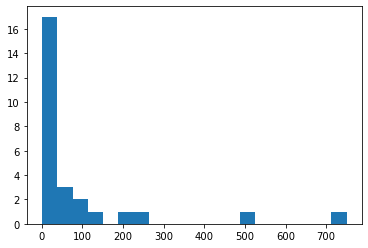

In [9]:
ls_City_values = list(Counter(df_p1_customers['City']).values())
plt.hist(ls_City_values, bins=20)
plt.show()

In [10]:
ls_other_Cities = []
for k, v in dict(Counter(df_p1_customers['City'])).items():
    if v < 150:
        ls_other_Cities.append(k)
        
dict_replace_Cities = {key: 'Other_Cities' for key in ls_other_Cities}

df_p1_customers.replace({'City': dict_replace_Cities}, inplace=True)
df_p1_mailinglist.replace({'City': dict_replace_Cities}, inplace=True)

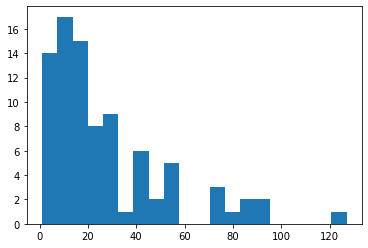

In [11]:
ls_ZIP_values = list(Counter(df_p1_customers['ZIP']).values())
plt.hist(ls_ZIP_values, bins=20)
plt.show()

In [12]:
len(dict(Counter(df_p1_customers['ZIP'])).keys())

86

In [13]:
ls_other_ZIPs = []
for k, v in dict(Counter(df_p1_customers['ZIP'])).items():
    if v < 40:
        ls_other_ZIPs.append(k)
        
dict_replace_ZIPs = {key: 'Other_ZIP' for key in ls_other_ZIPs}

df_p1_customers.replace({'ZIP': dict_replace_ZIPs}, inplace=True)
df_p1_mailinglist.replace({'ZIP': dict_replace_ZIPs}, inplace=True)

In [14]:
df_p1_customers.columns

Index(['Name', 'Customer_Segment', 'Customer_ID', 'Address', 'City', 'State', 'ZIP', 'Avg_Sale_Amount', 'Store_Number', 'Responded_to_Last_Catalog', 'Avg_Num_Products_Purchased', '#_Years_as_Customer'], dtype='object')

In [15]:
df_features = df_p1_customers.drop(columns=['Name', 'Customer_ID', 'Address', 'State', 
                                            'Avg_Sale_Amount', 'Responded_to_Last_Catalog'])
df_labels = df_p1_customers['Avg_Sale_Amount']

# Features preprocessing

In [26]:
# Import train_test_split
from sklearn.model_selection import train_test_split

# Split the 'features' and 'accuracy_group' data into training and testing sets
X_train, X_val, y_train, y_val = train_test_split(df_features, 
                                                    df_labels, 
                                                    test_size = 0.2, 
                                                    random_state = 42)

# # Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
# print("Validation set has {} samples.".format(X_valid.shape[0]))
print("Validation set has {} samples.".format(X_val.shape[0]))

Training set has 1900 samples.
Validation set has 475 samples.


In [17]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Inspired by https://medium.com/vickdata/a-simple-guide-to-scikit-learn-pipelines-4ac0d974bdcf

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

onehot_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(missing_values=np.NaN, strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='error', drop='first'))])


In [18]:
numeric_features = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', onehot_transformer, categorical_features)])


In [19]:
pipe = Pipeline(steps=[('preprocessor', preprocessor),])
X_train_transformed = pipe.fit_transform(X_train)
X_val_transformed = pipe.transform(X_val)
X_test_transformed = pipe.transform(df_p1_mailinglist)

onehot_features = list(pipe['preprocessor'].transformers_[1][1]['onehot'].get_feature_names(categorical_features))

X_train_transformed = pd.DataFrame.sparse.from_spmatrix(X_train_transformed, 
                                   columns=list(numeric_features) + list(onehot_features), 
                                     index=X_train.index)[list(numeric_features) + list(onehot_features)].astype(float)
X_val_transformed = pd.DataFrame.sparse.from_spmatrix(X_val_transformed, 
                                  columns=list(numeric_features) + list(onehot_features), 
                                 index=X_val.index)[list(numeric_features) + list(onehot_features)].astype(float)
X_test_transformed = pd.DataFrame.sparse.from_spmatrix(X_test_transformed, 
                                  columns=list(numeric_features) + list(onehot_features), 
                                 index=df_p1_mailinglist.index)[list(numeric_features) + list(onehot_features)].astype(float)


/Users/leehongkai/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/compose/_column_transformer.py:440: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  FutureWarning)


In [50]:
from sklearn import linear_model
import statsmodels.api as sm

clf = linear_model.Lasso(alpha=0.1)
clf.fit(X_train_transformed, y_train) 
ls_coeff_wGradient = []
for feature, _coeff in zip(X_train_transformed.columns, clf.coef_):
    if np.abs(_coeff) > 0:
        ls_coeff_wGradient.append(feature)
        
print('Total variables from lasso: ', len(ls_coeff_wGradient))

# Use statsmodels to assess variables
ols_model=sm.OLS(y_train, sm.add_constant(X_train_transformed[ls_coeff_wGradient], has_constant='add'))
result=ols_model.fit()
stats=result.summary()
print(stats)


Total variables from lasso:  35
                            OLS Regression Results                            
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     281.9
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:01:08   Log-Likelihood:                -12052.
No. Observations:                1900   AIC:                         2.418e+04
Df Residuals:                    1864   BIC:                         2.438e+04
Df Model:                          35                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

In [55]:
# Filtering only for significant p
df_pvalues = pd.DataFrame(result.pvalues, columns=['pvalue']).sort_values(['pvalue'])
ls_significant_variables = list(df_pvalues[df_pvalues.pvalue < 0.025].index)
print('\nTotal significant variables: ', len(ls_significant_variables))

ls_coeff_wGradient_significant = [x for x in ls_coeff_wGradient if x in ls_significant_variables]
# ls_coeff_wGradient_significant = ['Avg_Num_Products_Purchased', 'Customer_Segment_Loyalty Club and Credit Card']
# Use statsmodels to assess variables
ols_model_optimized =sm.OLS(y_train, sm.add_constant(X_train_transformed[ls_coeff_wGradient_significant], has_constant='add'))
model_optimized =ols_model_optimized.fit()
stats_optimized=model_optimized.summary()
print(stats_optimized)

# X_val_transformed
prediction = model_optimized.get_prediction(sm.add_constant(X_val_transformed[ls_coeff_wGradient_significant], has_constant='add'))
df_OLS_prediction=prediction.summary_frame(alpha=0.05)
df_OLS_prediction['Avg_Sale_Amount'] = y_val
df_OLS_prediction

def MSE(y, Y):
    return np.mean((y-Y)**2)

MSE(df_OLS_prediction['Avg_Sale_Amount'], df_OLS_prediction['mean'])


Total significant variables:  6
                            OLS Regression Results                            
Dep. Variable:        Avg_Sale_Amount   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.837
Method:                 Least Squares   F-statistic:                     1946.
Date:                Sat, 12 Dec 2020   Prob (F-statistic):               0.00
Time:                        17:02:22   Log-Likelihood:                -12076.
No. Observations:                1900   AIC:                         2.416e+04
Df Residuals:                    1894   BIC:                         2.420e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------

16850.672909589295

In [74]:
# X_test_transformed
prediction = model_optimized.get_prediction(sm.add_constant(X_test_transformed[ls_coeff_wGradient_significant], has_constant='add'))
df_OLS_prediction=prediction.summary_frame(alpha=0.05)


In [75]:
df_OLS_prediction['Name'] = df_p1_mailinglist['Name']
df_OLS_prediction['Score_No'] = df_p1_mailinglist['Score_No']
df_OLS_prediction['Score_Yes'] = df_p1_mailinglist['Score_Yes']
df_p1_mailinglist['Predicted_Avg_Sale_Amount'] = df_OLS_prediction['mean'] * df_OLS_prediction['Score_Yes']
df_p1_mailinglist.head()

,Name,Customer_Segment,Customer_ID,Address,City,State,ZIP,Store_Number,Avg_Num_Products_Purchased,#_Years_as_Customer,Score_No,Score_Yes,Predicted_Avg_Sale_Amount
0,A Giametti,Loyalty Club Only,2213,5326 S Lisbon Way,Other_Cities,CO,80015,105,3.0,0.2,0.694964,0.305036,106.614552
1,Abby Pierson,Loyalty Club and Credit Card,2785,4344 W Roanoke Pl,Denver,CO,Other_ZIP,101,6.0,0.6,0.527275,0.472725,468.821051
2,Adele Hallman,Loyalty Club Only,2931,5219 S Delaware St,Other_Cities,CO,Other_ZIP,101,7.0,0.9,0.421118,0.578882,363.344529
3,Alejandra Baird,Loyalty Club Only,2231,2301 Lawrence St,Denver,CO,Other_ZIP,103,2.0,0.6,0.694862,0.305138,85.431587
4,Alice Dewitt,Loyalty Club Only,2530,5549 S Hannibal Way,Other_Cities,CO,80015,104,4.0,0.5,0.612294,0.387706,162.469180


In [77]:
df_p1_mailinglist['Predicted_Avg_Sale_Amount'].sum()*0.5 - (6.5 * 250)

22024.363062377157